# Acceleration Analysis

**Author:** Jonah Lee

**Date:** 2025-10-10

**Relevant Links:**
- Slack Discussion: https://ubcsolar.slack.com/archives/C05CALTRK6V/p1759383966933329
- Monday Item: https://ubcsolar26.monday.com/boards/9565353662/pulses/18162773792


## Imports

In [1]:
import data_tools
import numpy as np
import matplotlib.pyplot as plt
from data_tools import query
from datetime import datetime
import pytz
from ipywidgets import Datetime
from numba.np.npdatetime import datetime_eq_datetime_impl

## Data Acquisition

First we have to determine the sections of time for which to analyze.

Here is a plot of MotorRotatingSpeed (km/h) for FSGP 2025 on InfluxDB. Section 1 is Scrutineering and section 2 is the track race. Note the 100km/h spike. I suspect this would be when were testing/debugging the motor.

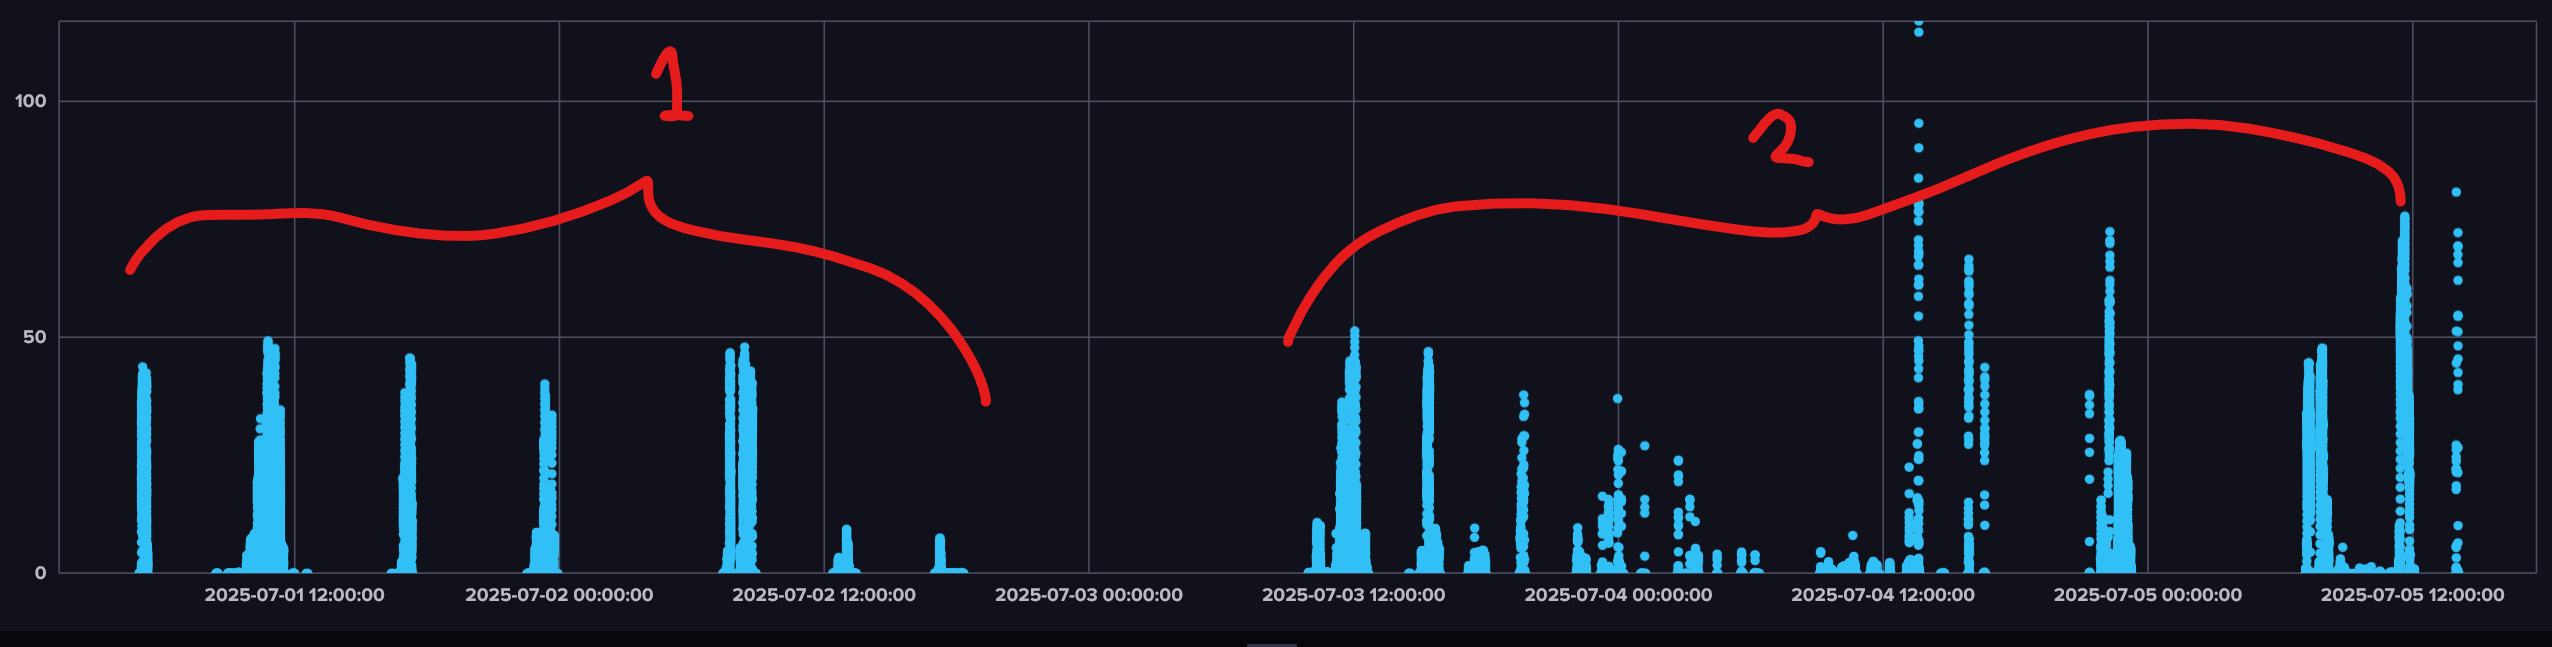

InfluxDB _thinks_ these are UTC timestamps. But I believe that our time zone conversions are still messed up, so I'll have to try to figure out for myself what the actual time was.
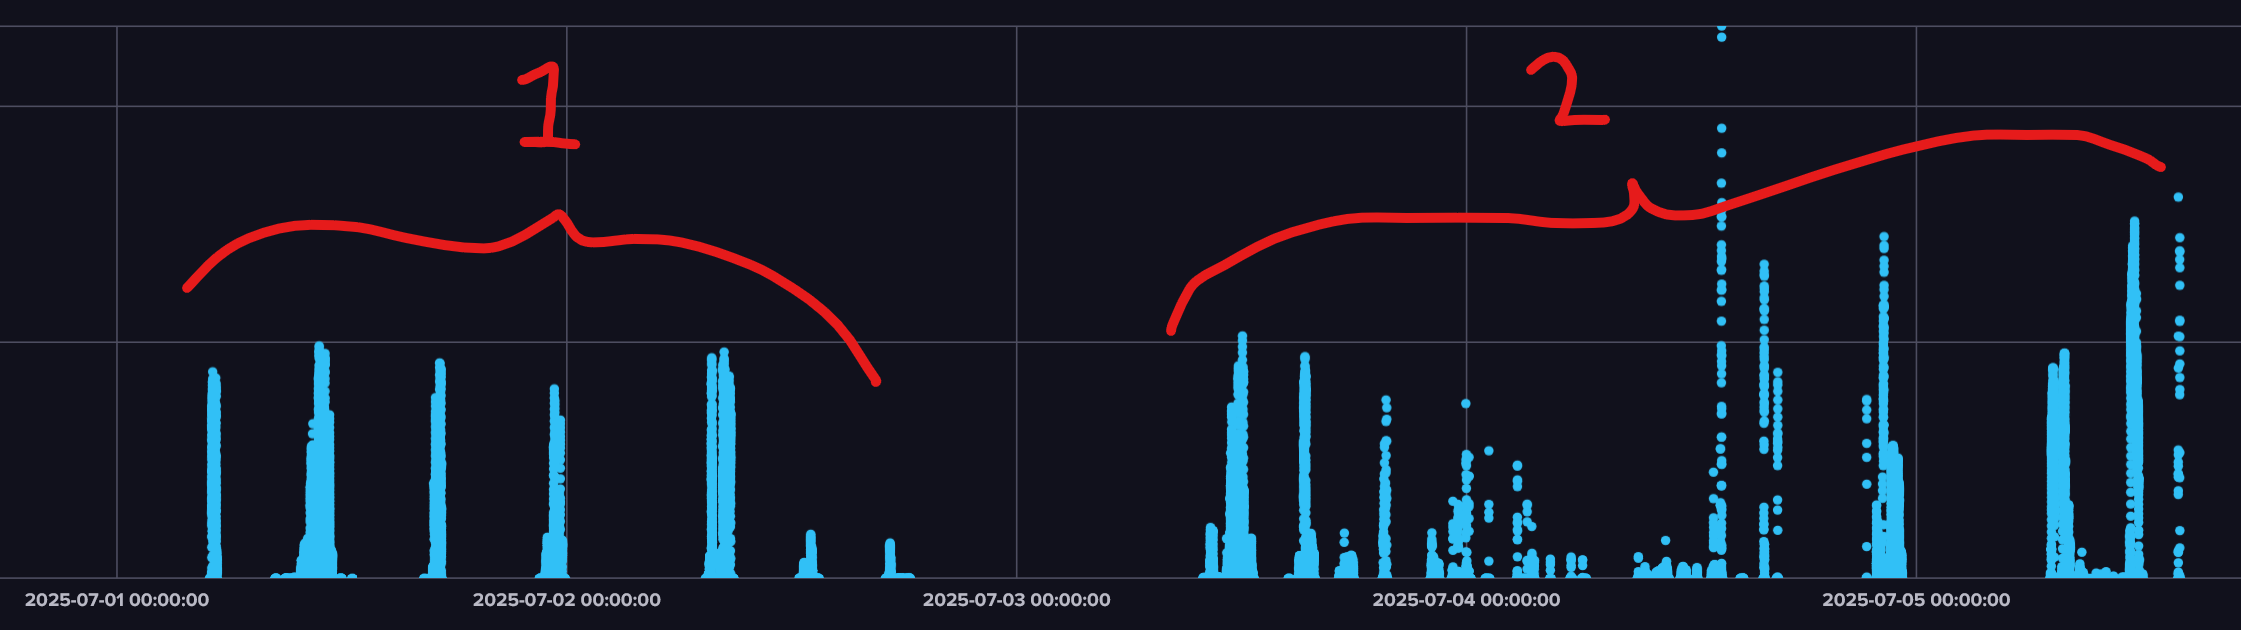

### Scrutineering Timestamps

I'll start by getting some of the start/stop times for the "spikes" in section 1.

I get the times by hovering over the scatter plot and copying the first/last timestamps shown per section.

I have to tell Influx that it's UTC time, but the data has incorrect timestamps so this isn't actually the real time.

In [2]:
# I hate this, but we have to convert local to UTC even though the local time is wrong
hour_fix = 7

# start/stop time pairs
# These are the first thee 'spikes'
scrutineering_timestamps: list[tuple[datetime, datetime]] = [
    (datetime(2025, 7, 1, 4 + hour_fix, 58, 56, tzinfo=pytz.UTC),
     datetime(2025, 7, 1, 5 + hour_fix, 20, 10, tzinfo=pytz.UTC)),
    (datetime(2025, 7, 1, 8 + hour_fix, 29, 25, tzinfo=pytz.UTC),
     datetime(2025, 7, 1, 12 + hour_fix, 33, 53, tzinfo=pytz.UTC)),
    (datetime(2025, 7, 1, 16 + hour_fix, 24, 28, tzinfo=pytz.UTC),
     datetime(2025, 7, 1 + 1, (17 + hour_fix) - 24, 19, 22, tzinfo=pytz.UTC)), # fix wraps to the next day
]


### FSGP (Track Day) Timestamps

Looks like the best on-track data we have is around 1:30PM Central Time, July 5th (Timestamp courtesy of Deev).
These laps were driven with UofT's motor, which could have slightly different acceleration characteristics.

The other two periods earlier that day are likely during motor testing.

This also confirms that **the timezone shown as UTC in InfluxDB is actually Vancouver time (UTC-7).**

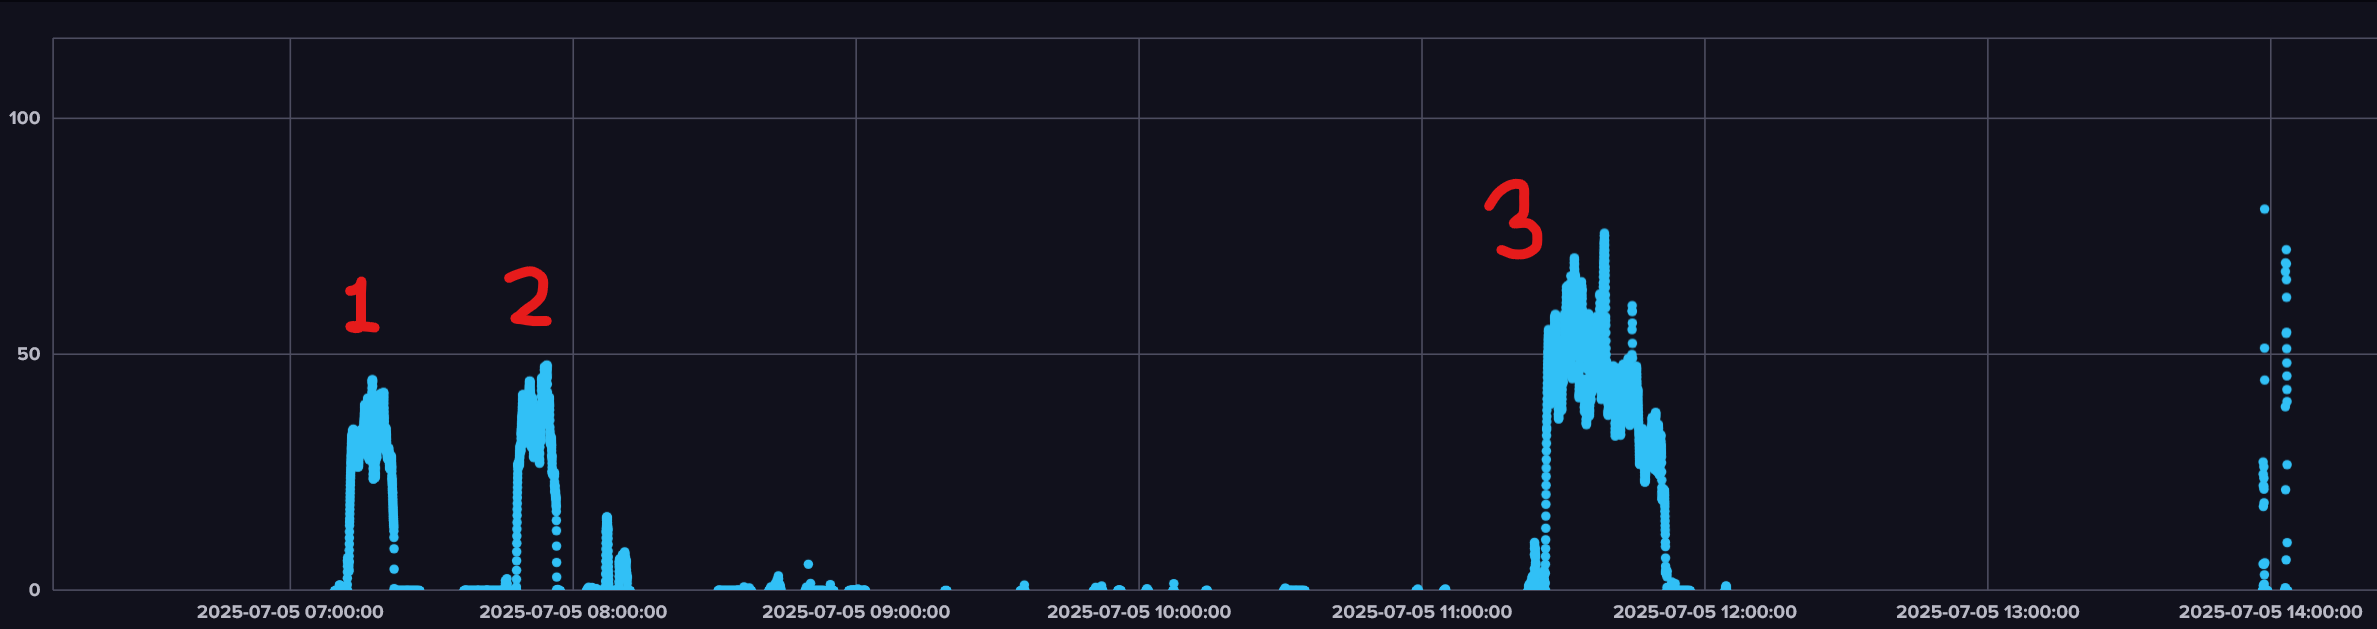

In [3]:
track_start_time = datetime(2025, 7, 5, 11 + hour_fix, 22, 41, tzinfo=pytz.UTC)
track_stop_time = datetime(2025, 7, 5, 11 + hour_fix, 56, 51, tzinfo=pytz.UTC)

### Querying Data

In [4]:
client = query.DBClient()

fields = ["MotorRotatingSpeed", "Acceleration_X", "Acceleration_Y", "Acceleration_Z"]

print("Collecting Scrutineering Data")
raw_scrutineering_data = []
for i, section in enumerate(scrutineering_timestamps):
    section_data = {}
    print(f"    Querying Section {i + 1}")
    for field in fields:
        print(f"        Queried {field}!")
        section_data[field] = client.query_time_series(track_start_time, track_stop_time, field)
    raw_scrutineering_data.append(section_data)

print("Collecting Track Day Data")
raw_track_data = {}
for field in fields:
    print(f"    Queried {field}!")
    raw_track_data[field] = client.query_time_series(track_start_time, track_stop_time, field)

    Querying Section 1
        Queried MotorRotatingSpeed!
        Queried Acceleration_X!
        Queried Acceleration_Y!
        Queried Acceleration_Z!
    Querying Section 2
        Queried MotorRotatingSpeed!
        Queried Acceleration_X!
        Queried Acceleration_Y!
        Queried Acceleration_Z!
    Querying Section 3
        Queried MotorRotatingSpeed!
        Queried Acceleration_X!
        Queried Acceleration_Y!
        Queried Acceleration_Z!
    Queried MotorRotatingSpeed!
    Queried Acceleration_X!
    Queried Acceleration_Y!
    Queried Acceleration_Z!


## Analysis

### Sanity Check

Let's start with the on-track data, and verify that the speeds look right to start.

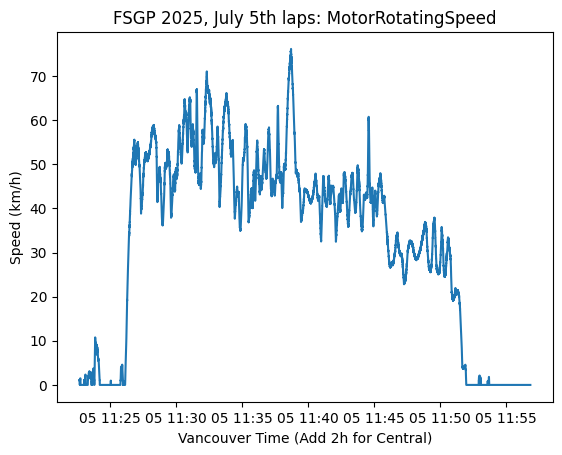

In [5]:
plt.plot(raw_track_data["MotorRotatingSpeed"].datetime_x_axis, raw_track_data["MotorRotatingSpeed"])
plt.ylabel("Speed (km/h)")
plt.xlabel("Vancouver Time (Add 2h for Central)")
plt.title("FSGP 2025, July 5th laps: MotorRotatingSpeed")
plt.show()

### Time Domain Acceleration (raw)

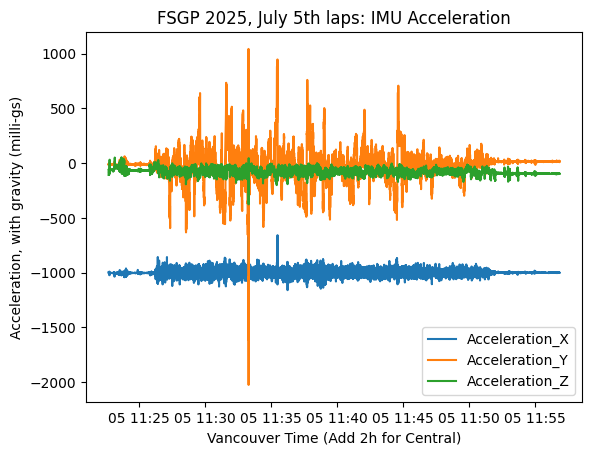

In [6]:
for direction in ("X", "Y", "Z"):
    plt.plot(raw_track_data[f"Acceleration_{direction}"].datetime_x_axis, raw_track_data[f"Acceleration_{direction}"],
             label=f"Acceleration_{direction}")
plt.ylabel("Acceleration, with gravity (milli-gs)")
plt.xlabel("Vancouver Time (Add 2h for Central)")
plt.title("FSGP 2025, July 5th laps: IMU Acceleration")
plt.legend(loc="lower right")
plt.show()

### Data Cleanup / Processing

#### Converting Axes & Units

A note on the IMU's X/Y/Z axes:
- The X axis points up
- The Y axis points to the right
- The Z axis points forward

It's pretty awkward, so I'll convert the data. I'll also convert it to gs instead of milli-gs.

In [7]:
def convert_accel_data(data: dict) -> dict:
    axis_map = {
        "Acceleration_X": "Acceleration_Up",
        "Acceleration_Y": "Acceleration_Right",
        "Acceleration_Z": "Acceleration_Forward",
    }
    processed_data = {}
    for key, val in data.items():
        if key in axis_map.keys():
            processed_data[axis_map[key]] = val / 1000. # convert to gs
        else:
            processed_data[key] = val
    return processed_data

scrutineering_data = [convert_accel_data(raw_data) for raw_data in raw_scrutineering_data]
track_data = convert_accel_data(raw_track_data)

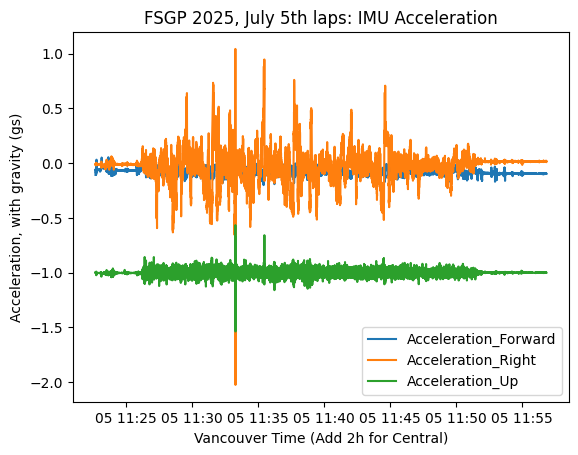

In [8]:
for direction in ("Forward", "Right", "Up"):
    plt.plot(track_data[f"Acceleration_{direction}"].datetime_x_axis, track_data[f"Acceleration_{direction}"],
             label=f"Acceleration_{direction}")
plt.ylabel("Acceleration, with gravity (gs)")
plt.xlabel("Vancouver Time (Add 2h for Central)")
plt.title("FSGP 2025, July 5th laps: IMU Acceleration")
plt.legend(loc="lower right")
plt.show()

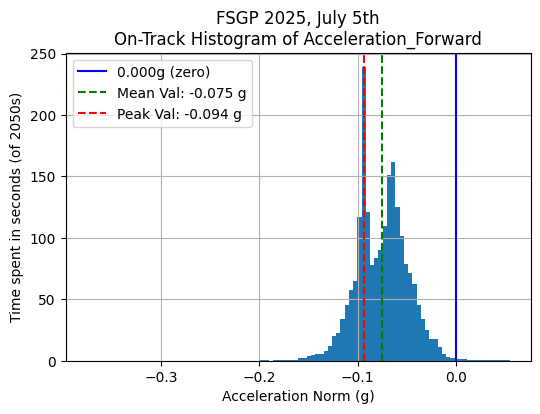

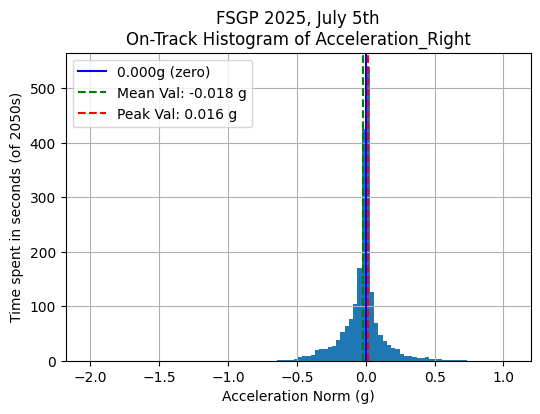

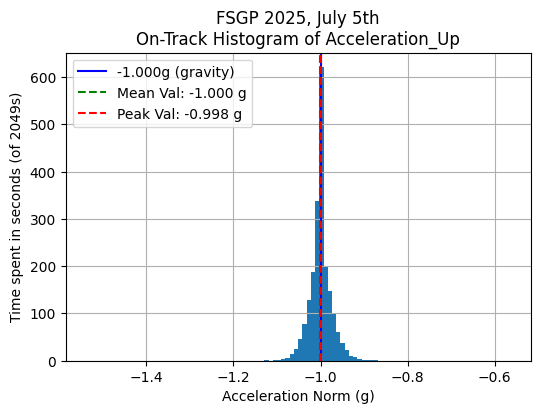

In [55]:
mode_accelerations: dict[str, float] = {}
mean_accelerations: dict[str, float] = {}

for field in ("Acceleration_Forward", "Acceleration_Right", "Acceleration_Up"):
    hist, bins = np.histogram(track_data[field], bins=100)

    # The y-direction now corresponds to seconds with this norm
    time_hist = hist * track_data[field].period

    # Time in seconds
    on_track_time = track_data[field].length

    # Mean & (binned) mode
    mean_acceleration = track_data[field].mean()
    mean_accelerations[field] = mean_acceleration
    mode_acceleration = 0.5 * (bins[np.argmax(time_hist)] + bins[np.argmax(time_hist) + 1])
    mode_accelerations[field] = mode_acceleration

    plt.figure(figsize=(6, 4))
    plt.stairs(time_hist, bins, fill=True)
    plt.ylabel(f"Time spent in seconds (of {on_track_time:.0f}s)")
    plt.xlabel("Acceleration Norm (g)")
    plt.title(f"FSGP 2025, July 5th\nOn-Track Histogram of {field}")
    if field == "Acceleration_Up":
        plt.axvline(x=-1.0, color="b", label=f"-1.000g (gravity)")
        # plt.xlim(-2.0, 0.0)
    else:
        plt.axvline(x=0.0, color="b", label=f"0.000g (zero)")
        # plt.xlim(-1.0, 1.0)

    plt.axvline(x=mean_acceleration, color="g", linestyle="--", label=f"Mean Val: {mean_acceleration:.3f} g")
    plt.axvline(x=mode_acceleration, color="r", linestyle="--", label=f"Peak Val: {mode_acceleration:.3f} g")
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

#### Fixing Bias

We can see by the mean and peak values that some components have a slight bias. The upwards direction seems fine (within 0.002g of expected), the rightwards direction has some slight differences between the mean, the peak, and zero, and the forwards direction has a significant bias towards negative accelerations.

Based on the fact that a negative forward acceleration is still present when the car is stationary (see the time-domain plot), I believe that this is an error and should be removed.

Corrections performed:
- Forward: subtract the mean, since we should expect the sum of acceleration to be 0 if we have no net change in velocity.
- Up: add a version with 1 g added, to cancel out gravity
- Right: This data seems fine; I'll leave it as-is

In [28]:
# Align data so they have matching time domains
a_f_aligned, a_u_aligned, a_r_aligned = track_data["Acceleration_Forward"].align(
    track_data["Acceleration_Forward"], track_data["Acceleration_Up"], track_data["Acceleration_Right"]
)

track_data_zeroed = {
    "Acceleration_Forward": a_f_aligned - mean_accelerations["Acceleration_Forward"],
    "Acceleration_Up": a_u_aligned,
    "Acceleration_Up_No_Gravity": a_u_aligned + 1.000,
    "Acceleration_Right": a_r_aligned
}

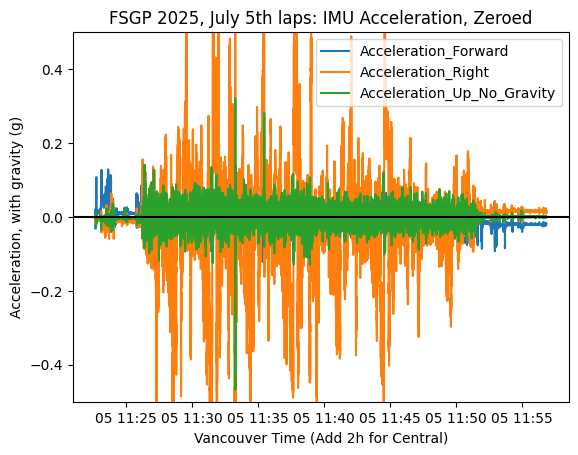

In [29]:
for direction in ("Forward", "Right"):
    plt.plot(track_data_zeroed[f"Acceleration_{direction}"].datetime_x_axis,
             track_data_zeroed[f"Acceleration_{direction}"],
             label=f"Acceleration_{direction}")
plt.plot(track_data_zeroed["Acceleration_Up_No_Gravity"].datetime_x_axis,
             track_data_zeroed["Acceleration_Up_No_Gravity"],
             label=f"Acceleration_Up_No_Gravity")
plt.axhline(y=0.0, color='k')
plt.ylabel("Acceleration, with gravity (g)")
plt.xlabel("Vancouver Time (Add 2h for Central)")
plt.title("FSGP 2025, July 5th laps: IMU Acceleration, Zeroed")
plt.legend(loc="upper right")
plt.ylim(-0.5, 0.5)
plt.show()

We can see from the above plot that the green (upwards) plot has almost no bias, but the orange and blue (right/forward) curves trend from positive to negative. I suspect this could occur when the car is not on level ground. Since the bias is pretty small relative to the actual values, I think it's appropriate to go forward with the analysis.

### Computing The Norm

After the data has been adjusted for bias in `track_data_zeroed`, we can compute the acceleration norm.

In [45]:
# Calculate the norm at any point in time using the pythagorean theorem

track_data_zeroed["Acceleration_Norm"] = track_data_zeroed["Acceleration_Forward"].promote(np.linalg.norm([
    track_data_zeroed["Acceleration_Forward"], track_data_zeroed["Acceleration_Right"], track_data_zeroed["Acceleration_Up"]
], axis=0))

track_data_zeroed["Acceleration_Norm_No_Gravity"] = track_data_zeroed["Acceleration_Forward"].promote(np.linalg.norm([
    track_data_zeroed["Acceleration_Forward"], track_data_zeroed["Acceleration_Right"], track_data_zeroed["Acceleration_Up_No_Gravity"]
], axis=0))


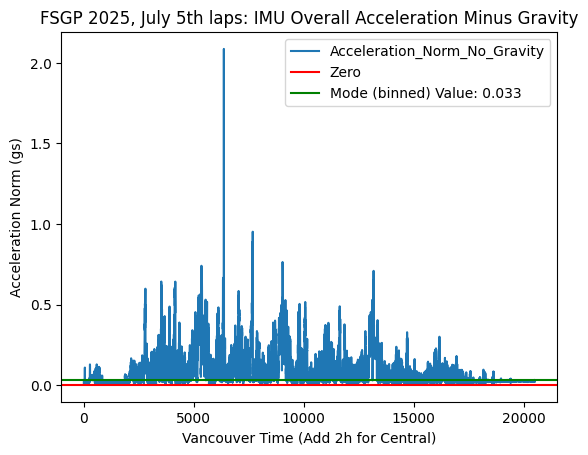

In [46]:
_h, _b = np.histogram(track_data_zeroed["Acceleration_Norm_No_Gravity"], bins=100)
mode_value = 0.5 * (_b[np.argmax(_h)] + _b[np.argmax(_h) + 1])

plt.plot(track_data_zeroed["Acceleration_Norm_No_Gravity"], label="Acceleration_Norm_No_Gravity")
plt.axhline(y=0.0, color="r", label="Zero")
plt.axhline(y=mode_value, color="g", label=f"Mode (binned) Value: {mode_value:.3f}")
plt.ylabel("Acceleration Norm (gs)")
plt.xlabel("Vancouver Time (Add 2h for Central)")
plt.title("FSGP 2025, July 5th laps: IMU Overall Acceleration Minus Gravity")
plt.legend(loc="best")
plt.show()

### Norm Histograms

With bias removed and norm calculated, we can now plot the distribution of acceleration norms.

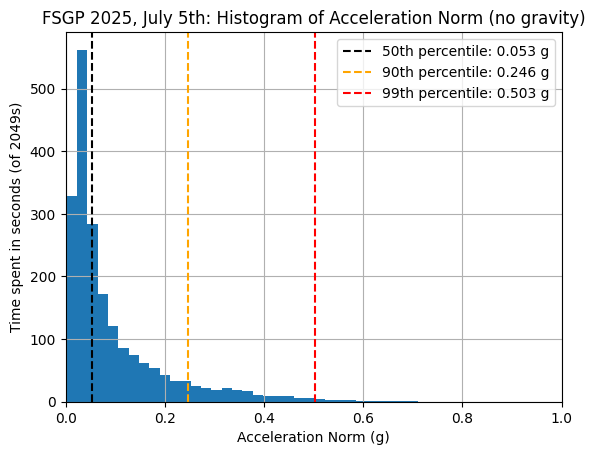

In [49]:
# Each data
hist, bins = np.histogram(track_data_zeroed["Acceleration_Norm_No_Gravity"], bins=100)

# The y-direction now corresponds to seconds with this norm
time_hist = hist * track_data_zeroed["Acceleration_Norm_No_Gravity"].period

# Time in seconds
on_track_time = track_data_zeroed["Acceleration_Norm_No_Gravity"].length

plt.stairs(time_hist, bins, fill=True)
plt.ylabel(f"Time spent in seconds (of {on_track_time:.0f}s)")
plt.xlabel("Acceleration Norm (g)")
plt.title("FSGP 2025, July 5th: Histogram of Acceleration Norm (no gravity)")
for percent_value, color in zip((50, 90, 99), ('black', 'orange', 'red')):
    percentile = np.percentile(track_data_zeroed["Acceleration_Norm_No_Gravity"], percent_value)
    plt.axvline(x=percentile, linestyle="--", color=color, label=f"{percent_value}th percentile: {percentile:.3f} g")
plt.legend(loc="best")
plt.xlim(0, 1.0)
plt.grid()
plt.show()

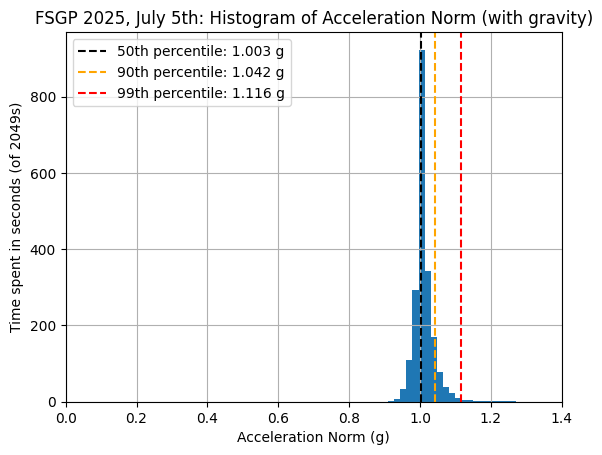

In [50]:

# Each data
hist, bins = np.histogram(track_data_zeroed["Acceleration_Norm"], bins=100)

# The y-direction now corresponds to seconds with this norm
time_hist = hist * track_data_zeroed["Acceleration_Norm"].period

# Time in seconds
on_track_time = track_data_zeroed["Acceleration_Norm"].length

plt.stairs(time_hist, bins, fill=True)
plt.ylabel(f"Time spent in seconds (of {on_track_time:.0f}s)")
plt.xlabel("Acceleration Norm (g)")
plt.title("FSGP 2025, July 5th: Histogram of Acceleration Norm (with gravity)")
for percent_value, color in zip((50, 90, 99), ('black', 'orange', 'red')):
    percentile = np.percentile(track_data_zeroed["Acceleration_Norm"], percent_value)
    plt.axvline(x=percentile, linestyle="--", color=color, label=f"{percent_value}th percentile: {percentile:.3f} g")
plt.legend(loc="best")
plt.grid()
plt.xlim(0, 1.4)
plt.show()

### High-Loading Scenarios

Now we can take a closer look at the high-loading scenarios to see what their vector components look like.

#### Without Gravity

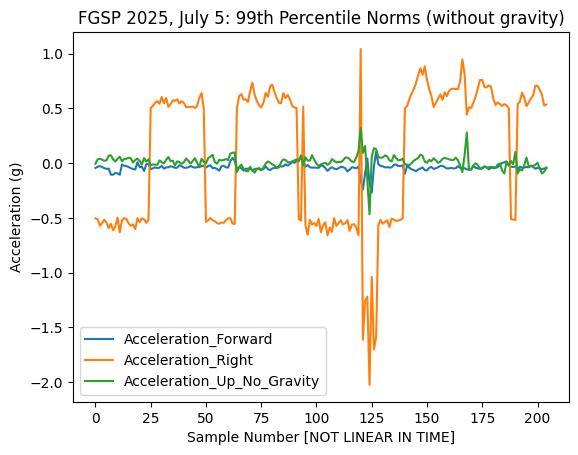

In [77]:
p99 = np.percentile(track_data_zeroed["Acceleration_Norm_No_Gravity"], 99)
high_load_indices = np.where(track_data_zeroed["Acceleration_Norm_No_Gravity"] > p99)

for direction in ("Forward", "Right", "Up_No_Gravity"):
    key = f"Acceleration_{direction}"
    plt.plot(track_data_zeroed[key][high_load_indices], label=key)
plt.legend(loc="best")
plt.title("FGSP 2025, July 5: 99th Percentile Norms (without gravity)")
plt.ylabel("Acceleration (g)")
plt.xlabel("Sample Number [NOT LINEAR IN TIME]")
plt.show()

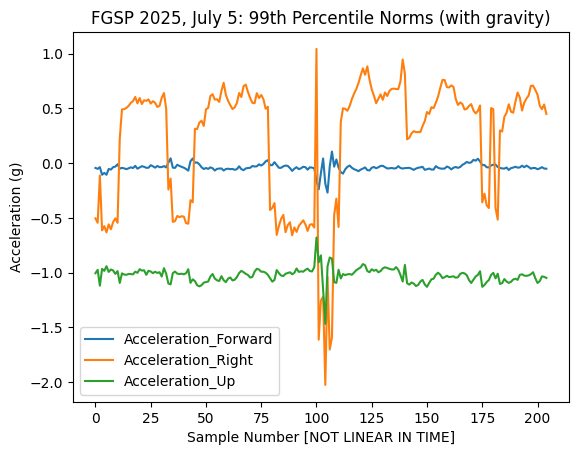

In [78]:
p99 = np.percentile(track_data_zeroed["Acceleration_Norm"], 99)
high_load_indices = np.where(track_data_zeroed["Acceleration_Norm"] > p99)

for direction in ("Forward", "Right", "Up"):
    key = f"Acceleration_{direction}"
    plt.plot(track_data_zeroed[key][high_load_indices], label=key)
plt.legend(loc="best")
plt.title("FGSP 2025, July 5: 99th Percentile Norms (with gravity)")
plt.ylabel("Acceleration (g)")
plt.xlabel("Sample Number [NOT LINEAR IN TIME]")
plt.show()